# This notebook shows how to solve a majority judgment

# 1. Basic functions

In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append('../')

import django
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "jmapp.settings")
django.setup()

from majority_judgment.tools import *

# 2. Generate data

In [2]:
# parameters    
Nratings     = 300
grades       = ["Excellent", "Good", "Fair", "Poor", "Reject"]
Ngrades      = len(grades)
candidates   = ["Bayrou", "Royal", "Sarkozy", "Voynet", "Besancenot", \
                "Buffet", "Bové", "Laguiller", "Nihous", "de Villiers", \
                "Schivardi", "Le Pen"]
Ncandidates  = len(candidates)

# generate data
results   = []
scores    = np.zeros((Ncandidates, Ngrades))

for i in range(Ncandidates):
    ratings = np.random.randint(0, Ngrades, Nratings)
    r       = Result(name = candidates[i], ratings = ratings, grades = grades)
    results.append(r)
    scores[i, :] = sorted_scores(ratings, Ngrades)

# 3. Visualize the sorted scores

<IPython.core.display.Javascript object>


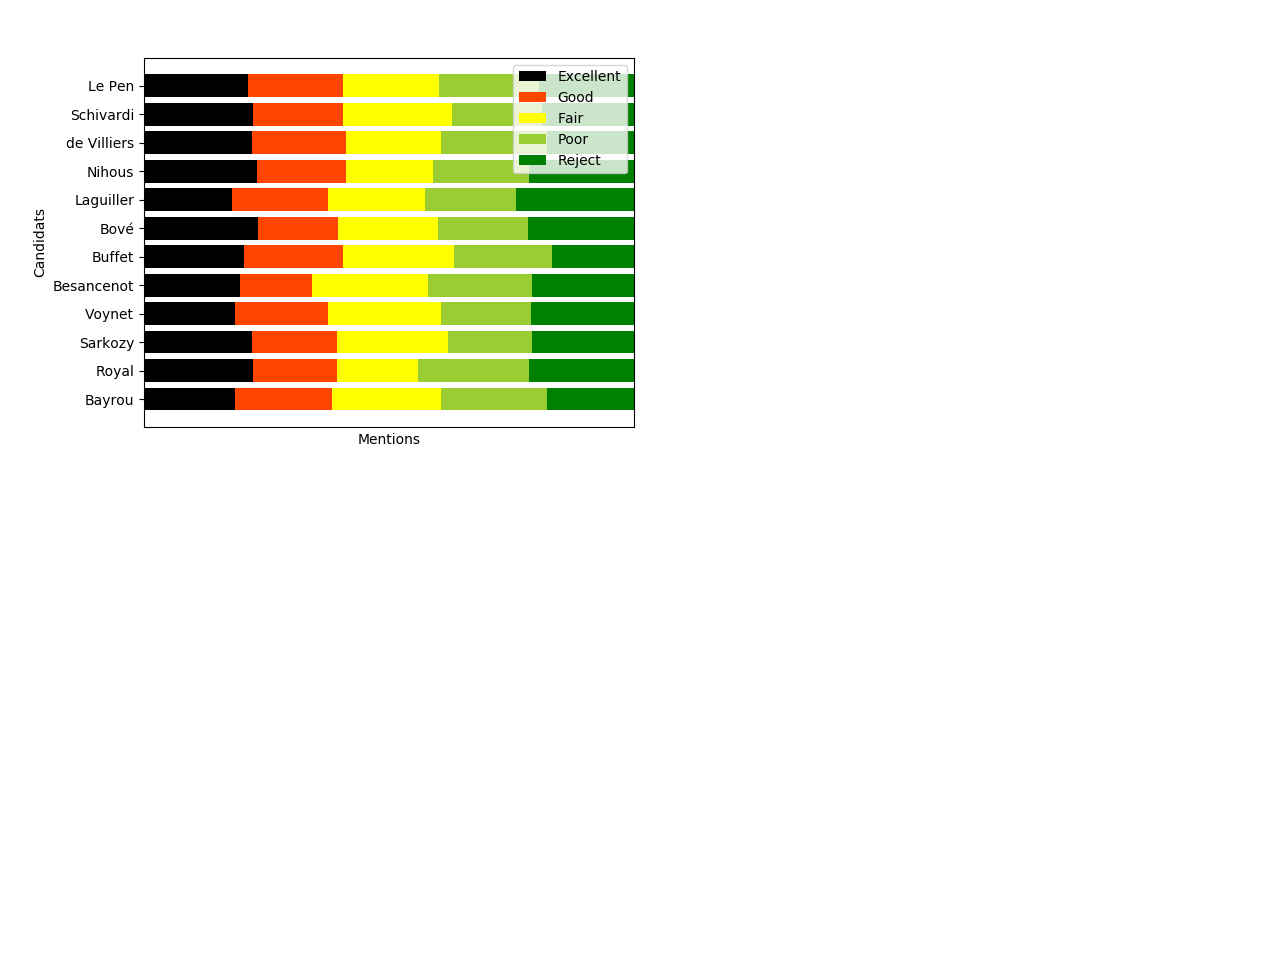

In [3]:
# colors from mieux choisir
colors = ['#5555AA', '#5E84C2', '#008080', '#ED5960', '#BB0000']
# colors from matplotlib
colors = [plt.cm.plasma(1-k/Ngrades, 1) for k in range(Ngrades)]
# colors from wikipedia majority judgment
colors = [ "black", "orangered", "yellow", "YellowGreen", "green"] 

plot_scores(scores, grades, names=candidates, height = 0.8, color = colors)
plt.show()

# 4. Final results

In [4]:
res = majority_judgment(results)
print("Ranking is: " + ", ".join(map(str, res)))

Ranking is: Nihous, de Villiers, Buffet, Schivardi, Royal, Besancenot, Laguiller, Le Pen, Voynet, Bayrou, Sarkozy, Bové


# 5. With the Django database


/Users/pierre-louis/.pyenv/versions/app/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


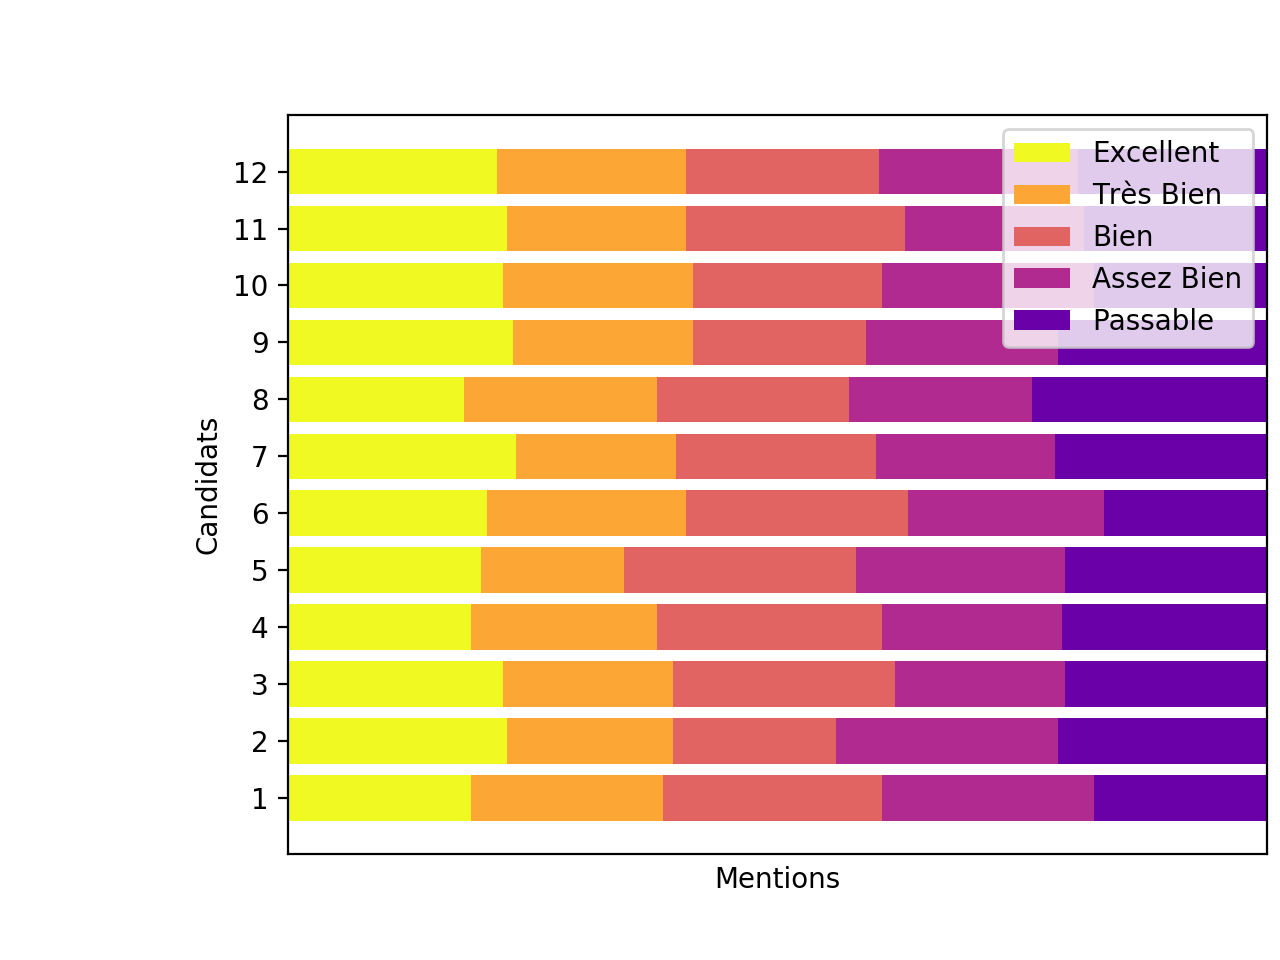

In [8]:
# read database
grades  = [g.name for g in Grade.objects.all()]
ratings = get_ratings(2)
names   = []
results = []
cs      = Candidate.objects.all()

for i in range(len(cs)):
    result = Result(candidate = cs[i], ratings = ratings[i, :], grades = grades)
    results.append(result)
    names.append(result.candidate.pk)

# display figure
fig = plt.figure()
ax = fig.add_subplot(111)
plot_scores(scores, grades=grades,  names=names, figure=fig)
plt.show()

# 6. From a fixture

We need first to load data from fixtures. Something like this:

     from django.core.management import call_command
     fixtures= ["election.json"]
     call_command('loaddata', *fixtures)


Ranking is 
[2, 3, 4, 13, 6, 7, 15, 14, 8, 12, 16, 5, 11, 17, 10, 1, 9]
It is supposed to be: 
[2, 3, 4, 13, 6, 7, 15, 14, 8, 12, 16, 5, 11, 17, 10, 1, 9]


/Users/pierre-louis/.pyenv/versions/app/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


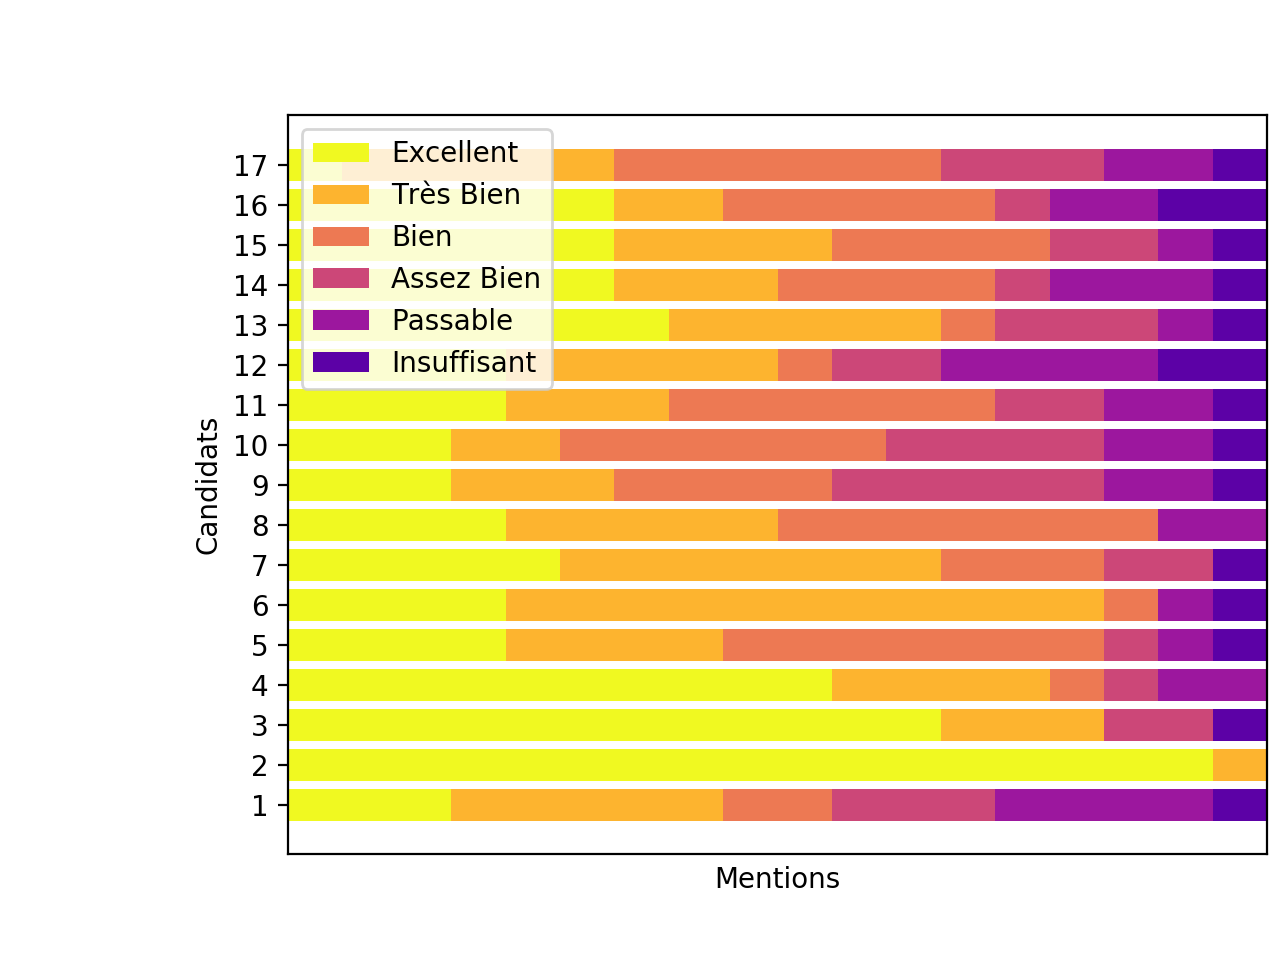

In [2]:
election_id = 2
election = Election.objects.get(pk=election_id)
ranking = get_ranking(election_id)
ranking = [candidate.pk for candidate in ranking]
print("Ranking is ")
print(ranking)
print("It is supposed to be: ")
print([ 2,  3,  4, 13,  6,  7, 15, 14,  8, 12, 16,  5, 11, 17, 10,  1,  9])

grades  = [g.name for g in Grade.objects.filter(election=election)]
scores  = get_scores(election)
names   = []
for c in Candidate.objects.filter(election=election):
    name = c.user.first_name.title() + " " + c.user.last_name.title()
    names.append(c.pk)


# display figure
fig = plt.figure()
ax = fig.add_subplot(111)
plot_scores(scores, grades=grades,  names=names, figure=fig)
plt.show()

In [18]:
ratings = get_ratings(election)
first = ratings[0]
second = ratings[10]
print("Candidate: {:d}, ranking: {}".format(names[0], ratings[0]))
print("Candidate: {:d}, ranking: {}".format(names[10], ratings[10]))


def tie_breaking(A, B):
    ''' Algorithm to divide out candidates with the same median grade.
    Return True if A < B (or if B has a better ranking than A)'''

    Ac   = np.copy(A)
    Bc   = np.copy(B)
    medA = majority_grade(Ac)
    medB = majority_grade(Bc)
    print(medA)
    print(medB)
    while medA == medB:
        Ac[medA] -= 1
        Bc[medB] -= 1
        if Ac[medA] < 0:
            return True
        if Bc[medB] < 0:
            return False
        medA = majority_grade(Ac)
        medB = majority_grade(Bc)
        print(medA)
        print(Ac)
        print(medB)
        print(Bc)
    return medA > medB


print(tie_breaking(first, second))

Candidate: 1, ranking: [3. 5. 2. 3. 4. 1.]
Candidate: 11, ranking: [4. 3. 6. 2. 2. 1.]
2
2
2
[3. 5. 1. 3. 4. 1.]
2
[4. 3. 5. 2. 2. 1.]
1
[3. 5. 0. 3. 4. 1.]
2
[4. 3. 4. 2. 2. 1.]
False


In [16]:
def majority_grade(x):
    mid = sum(x)/2.0
    acc = 0
    for i, xi in enumerate(x[::-1]):
        acc += xi
        if acc > mid:
            return len(x) - 1 - i
        
print(majority_grade(first))


def majority_value(x):
    mid = sum(x)/2.0
    acc = 0
    for i, xi in enumerate(x[::-1]):
        acc += xi
        if acc > mid:
            return len(x) - 1 - i

0
